In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Use GPU
torch.cuda.is_available()
device = torch.device("cuda:0")
print(device)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Data preprocessing. Set to True if need to change something in training data.
REBUILD_DATA = True

class ProstateVSCancer(): 
   # ////////////////////////////////////////////////////////////////////////////////////////////////////////

    IMG_SIZE = 128 # Image will be 128x128 
    PROSTATE = "D://Projects//test//data//Images//ax1_3//" # Path to prostate images
    CANCER = "D://Projects//test//data//Images//sag1_3//" # Path to cancer images
    
   # ////////////////////////////////////////////////////////////////////////////////////////////////////////
    LABELS = {PROSTATE: 0, CANCER: 1} # Represent prostate as zeros, cancer as ones
    training_data = [] # Will be filled with preprocessed images of prostate and cancer and their labels respectively
    
    # To see if data well balanced create counters for classes of images
    prostatecount = 0 # Counter for prostate as we append training_data
    cancercount = 0 # same for cancer
    
    def make_training_data(self):
        for label in self.LABELS: # Iteratare through the keys of dictionarie LABELS
            print(label)
            # Iterate throught all images in directories PROSTATE and CANCER
            for f in tqdm(os.listdir(label)): # Access to the directories
                if "jpg" in f: # Ignore all file that are not images
                    try:
                        path = os.path.join(label, f) # Join path to image and image's name in a single string
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Read images from path and convert to the grey scale. MAKES AN ARRAY!
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE)) # Resize images to 128x128
                        # Add all data in one-hot vectors to the list
                        # np.eye(2) - one-hot for 2 classes, array 2x2
                        # np.eye(10)[7] returns an array with 10 elements and element with index 7 is one, rest are zeroes
                        # np.eye(2)[self.LABELS[label]] - convert all prostate and cancer to one-hot
                        self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])

                        if label == self.PROSTATE:
                            self.prostatecount += 1
                        elif label == self.CANCER:
                            self.cancercount += 1
                    except Exception as e:
                        print(str(e))
                        #pass
                
        np.random.shuffle(self.training_data)
        np.save("D://Projects//test//data//training_data.npy", self.training_data)
        print("Prostate: ", self.prostatecount)
        print("Cancer: ", self.cancercount)

if REBUILD_DATA:
    prostatecancer = ProstateVSCancer()
    prostatecancer.make_training_data()
    
training_data = np.load("D://Projects//test//data//training_data.npy", allow_pickle=True)
print("Number of samples: ", len(training_data))

print("DATA PREPROCESSED")

cuda:0
Running on CPU
D://Projects//test//data//Images//ax1_3//


100%|██████████| 130/130 [00:01<00:00, 114.74it/s]


D://Projects//test//data//Images//sag1_3//


100%|██████████| 130/130 [00:00<00:00, 167.10it/s]


Prostate:  130
Cancer:  130
Number of samples:  260
DATA PREPROCESSED


AttributeError: 'AxesImage' object has no attribute 'view'

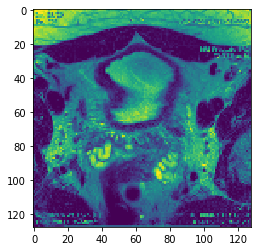

In [2]:
test = training_data[0][0]

plt.imshow(test).view(1, 128, 128)
plt.show

In [3]:
# Define neural network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(128, 128).view(-1, 1, 128, 128)
        self._to_linear = None
        self.convs(x)        
        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        #print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
    
net = Net().to(device)

print("Network Architecture")
print(net)

Network Architecture
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [4]:
# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 1, 128, 128)
#X = torch.Tensor([i[0] for i in training_data]).view(-1, 128, 128)
X = X / 255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)

print("Validation size: ", val_size)

# Define number of training and test samples
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("Number of training samples: ", len(train_X))
print("Number of test samples: ", len(test_X))

Validation size:  26
Number of training samples:  234
Number of test samples:  26


begin the training


100%|██████████| 8/8 [00:37<00:00,  4.10s/it]


Epoch:  0 Loss:  0.248


100%|██████████| 8/8 [00:34<00:00,  3.83s/it]


Epoch:  1 Loss:  0.247


100%|██████████| 8/8 [00:35<00:00,  3.94s/it]


Epoch:  2 Loss:  0.235


100%|██████████| 8/8 [00:34<00:00,  3.83s/it]


Epoch:  3 Loss:  0.18
Losses:  [0.252, 0.372, 0.25, 0.254, 0.251, 0.262, 0.25, 0.248, 0.254, 0.251, 0.25, 0.251, 0.251, 0.248, 0.248, 0.247, 0.251, 0.249, 0.248, 0.249, 0.248, 0.244, 0.242, 0.235, 0.246, 0.239, 0.23, 0.229, 0.222, 0.264, 0.216, 0.18]
Loss value:  0.18


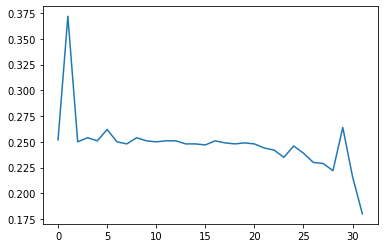

In [5]:
# Training
BATCH_SIZE = 32
EPOCHS = 4

def train(net):
    print("begin the training")
    losses = []
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            #print(i, i + BATCH_SIZE)
            batch_X = train_X[i: i + BATCH_SIZE].view(-1, 1, 128, 128)
            batch_y = train_y[i: i + BATCH_SIZE]
            
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()
            
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            losses.append(round(float(loss), 3))
            loss.backward()
            optimizer.step()
        
        print("Epoch: ", epoch, "Loss: ", round(float(loss), 3))
    
    print("Losses: ", losses)
    print("Loss value: ", round(float(loss), 3))
    plt.plot(losses)
    plt.show()
    
train(net)

In [6]:
# Accuracy test
def test(net):
    print("begin the test")
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 128, 128).to(device))[0]

            #print("Real class: ", real_class, "Net out: ", net_out)

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct / total, 3))
    

test(net)

print("DONE")

begin the test


100%|██████████| 26/26 [00:02<00:00, 10.71it/s]


Accuracy:  0.692
DONE
